In [1]:
from pathlib import Path
import pandas as pd
import sys
import sklearn

recipe = pd.read_csv(Path("recipe_popularity_prediction.csv"))

In [2]:
recipe.head() #based on these three factors, predicting how popular the recipe becomes

,num_ingredients,cooking_time_minutes,difficulty_level,popularity_views
0,8,69,Easy,6037
1,3,174,Easy,8558
2,6,143,Hard,2191
3,14,15,Medium,1276
4,6,48,Hard,3541


In [12]:
recipe["difficulty_level"].value_counts()

difficulty_level
Hard      346
Medium    335
Easy      319
Name: count, dtype: int64

In [13]:
recipe.describe()

,num_ingredients,cooking_time_minutes,popularity_views
count,1000.000000,1000.000000,1000.00000
mean,8.372000,93.754000,5959.19700
std,3.406938,47.970936,4244.32887
min,3.000000,10.000000,9.00000
25%,6.000000,52.000000,2603.75000
50%,8.000000,93.500000,5413.00000
75%,11.000000,133.000000,8404.75000
max,14.000000,179.000000,23765.00000


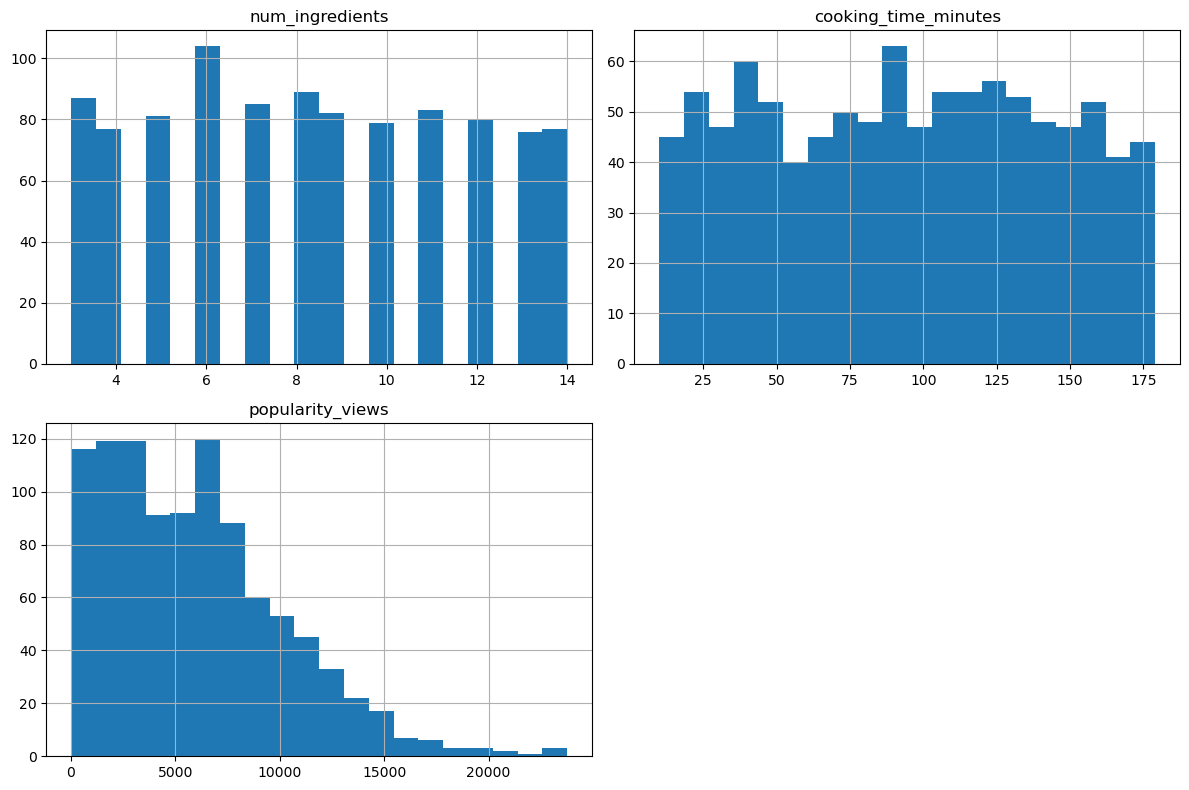

In [14]:
import matplotlib.pyplot as plt

IMAGES_PATH = Path() / "images"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

recipe.hist(bins=20, figsize=(12, 8))
save_fig("histogram_plots")
plt.show()

In [15]:
recipe_cat = recipe[["difficulty_level"]]
recipe_cat.head(8)

,difficulty_level
0,Easy
1,Easy
2,Hard
3,Medium
4,Hard
5,Easy
6,Easy
7,Medium


In [16]:
recipe.head(8)

,num_ingredients,cooking_time_minutes,difficulty_level,popularity_views,time_cat
0,8,69,Easy,6037,2
1,3,174,Easy,8558,5
2,6,143,Hard,2191,4
3,14,15,Medium,1276,1
4,6,48,Hard,3541,2
5,10,173,Easy,1982,5
6,12,98,Easy,1712,3
7,6,94,Medium,2145,3


<Axes: xlabel='time_cat'>

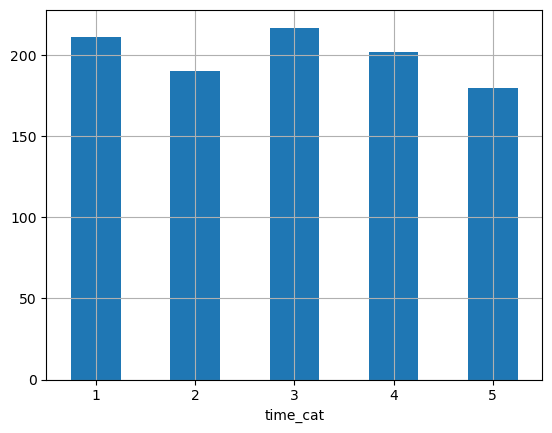

In [17]:
#hypothesis: difficulty_level is highly correlated with cooking time + small data size = stratified sample based on cooking time
from sklearn.model_selection import train_test_split
import numpy as np

recipe["time_cat"] = pd.cut(recipe["cooking_time_minutes"],
                            bins=[0., 44., 78., 112., 146., np.inf], 
                            labels=[1, 2, 3, 4, 5])
recipe["time_cat"].value_counts().sort_index().plot.bar(rot=0, grid=True)



In [18]:
train_set, test_set = train_test_split(recipe, test_size=0.2, stratify=recipe["time_cat"], random_state=42)

In [19]:
test_set["time_cat"].value_counts() / len(test_set)

time_cat
3    0.22
1    0.21
4    0.20
2    0.19
5    0.18
Name: count, dtype: float64

In [20]:
recipe["time_cat"].value_counts() / len(recipe)

time_cat
3    0.217
1    0.211
4    0.202
2    0.190
5    0.180
Name: count, dtype: float64

In [21]:
for set_ in (recipe, train_set, test_set):
    set_.drop("time_cat", axis=1, inplace=True)

In [22]:
corr = recipe.corr(numeric_only=True)

In [23]:
corr["popularity_views"].sort_values(ascending=False)

popularity_views        1.000000
cooking_time_minutes    0.347948
num_ingredients         0.005077
Name: popularity_views, dtype: float64

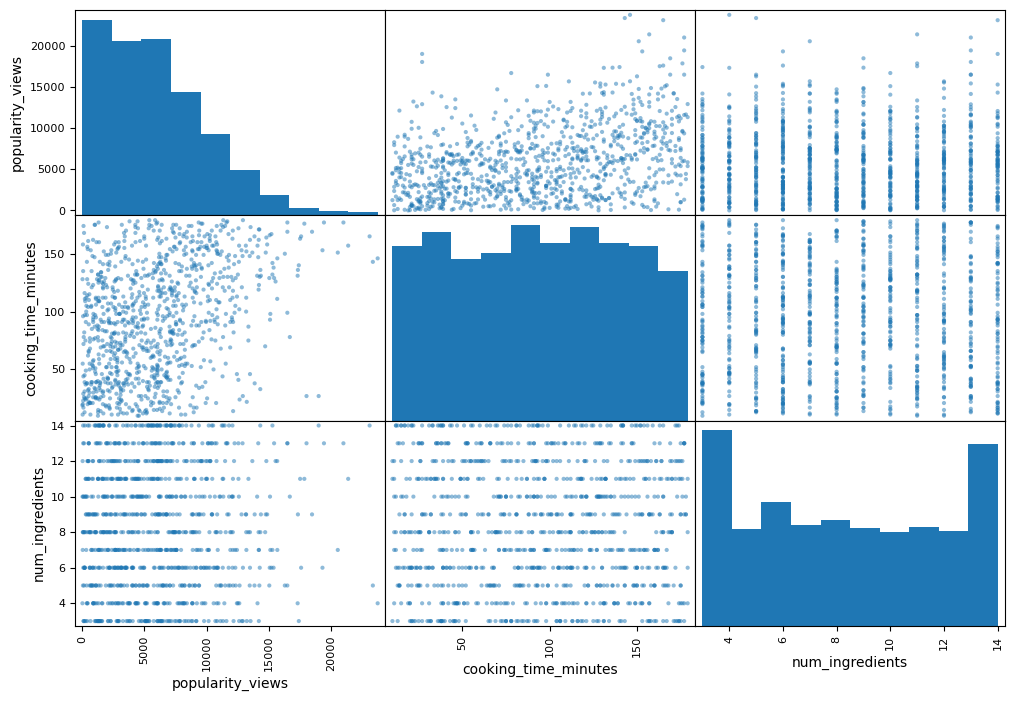

In [24]:
from pandas.plotting import scatter_matrix

scatter_matrix(recipe[["popularity_views", "cooking_time_minutes", "difficulty_level", "num_ingredients"]],
               figsize=(12, 8))
plt.show()


<Axes: xlabel='cooking_time_minutes', ylabel='popularity_views'>

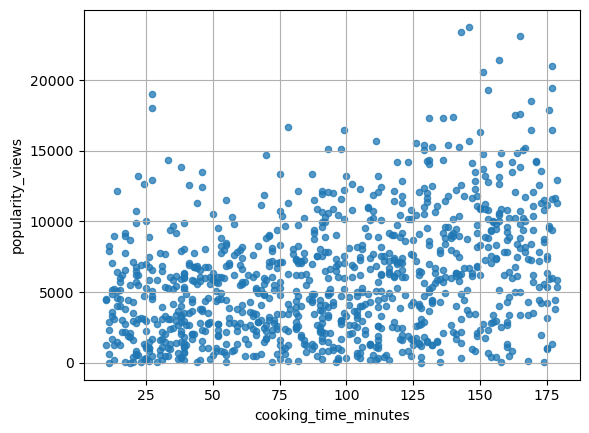

In [25]:
recipe.plot(kind="scatter", x="cooking_time_minutes", y="popularity_views", alpha=0.75, grid=True)

In [26]:
recipe = train_set.drop("popularity_views", axis=1)
recipe_labels = train_set["popularity_views"].copy()

In [27]:
recipe.head()

,num_ingredients,cooking_time_minutes,difficulty_level
20,11,164,Hard
0,8,69,Easy
644,14,64,Medium
161,6,105,Easy
78,3,21,Easy


In [28]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([("standardize", StandardScaler())])

In [29]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder

num_attrib = ["num_ingredients", "cooking_time_minutes"]
cat_attrib = ["difficulty_level"]
diff_attrib = [["Easy", "Medium", "Hard"]] # Ensures ordered correctly

cat_pipeline = Pipeline([("encode", OrdinalEncoder(categories=diff_attrib))])

preprocessing = ColumnTransformer([
    ("num", num_pipeline, num_attrib),
    ("cat", cat_pipeline, cat_attrib)])

In [30]:
recipe.head(8)

,num_ingredients,cooking_time_minutes,difficulty_level
20,11,164,Hard
0,8,69,Easy
644,14,64,Medium
161,6,105,Easy
78,3,21,Easy
702,4,109,Easy
667,8,59,Medium
779,11,49,Medium


In [31]:
recipe_prepared = preprocessing.fit_transform(recipe)

In [32]:
recipe_prepared.shape

(800, 3)

In [33]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

lin_reg = make_pipeline(preprocessing, LinearRegression())
lin_reg.fit(recipe, recipe_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('standardize',
                                                                   StandardScaler())]),
                                                  ['num_ingredients',
                                                   'cooking_time_minutes']),
                                                 ('cat',
                                                  Pipeline(steps=[('encode',
                                                                   OrdinalEncoder(categories=[['Easy',
                                                                                               'Medium',
                                                                                               'Hard']]))]),
                                                  ['difficulty_level'])])),
                ('linearregression', LinearRegression())])

In [34]:
recipe_predictions = lin_reg.predict(recipe)

In [35]:
recipe_predictions[:5].round(-1)

array([8290., 5000., 4890., 6180., 3670.])

In [36]:
recipe_labels[:5].values

array([8402, 6037, 4291, 7515, 6218], dtype=int64)

In [37]:
from sklearn.metrics import mean_squared_error

lin_rmse = mean_squared_error(recipe_labels, recipe_predictions, squared=False)

In [38]:
lin_rmse #RMSE off by the whole standard deviation

4020.726378350862

In [39]:
recipe_labels.describe()

count      800.000000
mean      5985.425000
std       4295.025604
min          9.000000
25%       2566.750000
50%       5511.500000
75%       8640.250000
max      23765.000000
Name: popularity_views, dtype: float64

In [40]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = make_pipeline(preprocessing, DecisionTreeRegressor(random_state=42))
tree_reg.fit(recipe, recipe_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('standardize',
                                                                   StandardScaler())]),
                                                  ['num_ingredients',
                                                   'cooking_time_minutes']),
                                                 ('cat',
                                                  Pipeline(steps=[('encode',
                                                                   OrdinalEncoder(categories=[['Easy',
                                                                                               'Medium',
                                                                                               'Hard']]))]),
                                                  ['difficulty_level'])])),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(random_state=42))])

In [41]:
recipe_predictions = tree_reg.predict(recipe)

In [42]:
tree_rmse = mean_squared_error(recipe_labels, recipe_predictions, squared=False)

In [43]:
tree_rmse

1136.7084369463437

In [44]:
from sklearn.model_selection import cross_val_score

tree_rmses = -cross_val_score(tree_reg, recipe, recipe_labels, scoring="neg_root_mean_squared_error", cv=10)

In [45]:
pd.Series(tree_rmses).describe()

count      10.000000
mean     5706.427355
std       332.169702
min      4923.692619
25%      5622.070475
50%      5763.761549
75%      5858.390166
max      6181.603739
dtype: float64

In [55]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = Pipeline([("preprocessing", preprocessing), ("random_forest", RandomForestRegressor(random_state=42))])
forest_rmses = -cross_val_score(forest_reg, recipe, recipe_labels, scoring="neg_root_mean_squared_error", cv=10)

In [56]:
pd.Series(forest_rmses).describe()

count      10.000000
mean     4447.189595
std       346.208499
min      3878.438427
25%      4281.913088
50%      4427.657414
75%      4682.688673
max      4962.380985
dtype: float64

In [48]:
recipe.head()

,num_ingredients,cooking_time_minutes,difficulty_level
20,11,164,Hard
0,8,69,Easy
644,14,64,Medium
161,6,105,Easy
78,3,21,Easy


In [49]:
from sklearn.kernel_ridge import KernelRidge

kr_reg = make_pipeline(preprocessing, KernelRidge())
kr_rmses = -cross_val_score(kr_reg, recipe, recipe_labels, scoring="neg_root_mean_squared_error", cv=10)

In [50]:
pd.Series(kr_rmses).describe()

count      10.000000
mean     5358.784853
std       585.103985
min      4351.212749
25%      5098.726908
50%      5310.812053
75%      5846.780829
max      6046.098843
dtype: float64

In [54]:
from sklearn.neighbors import KNeighborsRegressor

kn_reg = Pipeline([("preprocessing", preprocessing), ("kn", KNeighborsRegressor(n_neighbors=5))])
kn_rmses = -cross_val_score(kn_reg, recipe, recipe_labels, scoring="neg_root_mean_squared_error", cv=10)

In [53]:
pd.Series(kn_rmses).describe()

count      10.000000
mean     4432.965738
std       429.097436
min      3648.069293
25%      4209.138374
50%      4535.560314
75%      4688.744000
max      5001.271663
dtype: float64

In [64]:
from sklearn.model_selection import GridSearchCV

param_grid ={'random_forest__max_features': [2, 4, 6, 8, 10]}
forest_grid=GridSearchCV(forest_reg, param_grid, cv=3, scoring='neg_root_mean_squared_error')
forest_grid.fit(recipe, recipe_labels)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('standardize',
                                                                                          StandardScaler())]),
                                                                         ['num_ingredients',
                                                                          'cooking_time_minutes']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('encode',
                                                                                          OrdinalEncoder(categories=[['Easy',
                                                                                                                      'Medium',
                                                                                                                      'Hard']]))]),
                                                                         ['difficulty_level'])])),
                                       ('random_forest',
                                        RandomForestRegressor(random_state=42))]),
             param_grid={'random_forest__max_features': [2, 4, 6, 8, 10]},
             scoring='neg_root_mean_squared_error')

In [65]:
forest_grid.best_params_

{'random_forest__max_features': 2}

In [69]:
forest_res = pd.DataFrame(forest_grid.cv_results_)
forest_res.sort_values(by="mean_test_score", ascending=False, inplace=True)

In [70]:
forest_res.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_random_forest__max_features,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.234567,0.021045,0.009986,0.000013,2,{'random_forest__max_features': 2},-4390.427746,-4524.858621,-4268.604275,-4394.630214,104.657594,1
1,0.259322,0.002406,0.010318,0.000488,4,{'random_forest__max_features': 4},-4422.042987,-4546.323666,-4322.601789,-4430.322814,91.521532,2
2,0.261009,0.004453,0.010278,0.000471,6,{'random_forest__max_features': 6},-4422.042987,-4546.323666,-4322.601789,-4430.322814,91.521532,2
3,0.267866,0.006265,0.009641,0.000470,8,{'random_forest__max_features': 8},-4422.042987,-4546.323666,-4322.601789,-4430.322814,91.521532,2
4,0.260833,0.003143,0.009632,0.000464,10,{'random_forest__max_features': 10},-4422.042987,-4546.323666,-4322.601789,-4430.322814,91.521532,2


In [79]:
kn_grid=GridSearchCV(kn_reg, {'kn__n_neighbors': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]}, cv=3, scoring='neg_root_mean_squared_error')
kn_grid.fit(recipe, recipe_labels)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('standardize',
                                                                                          StandardScaler())]),
                                                                         ['num_ingredients',
                                                                          'cooking_time_minutes']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('encode',
                                                                                          OrdinalEncoder(categories=[['Easy',
                                                                                                                      'Medium',
                                                                                                                      'Hard']]))]),
                                                                         ['difficulty_level'])])),
                                       ('kn', KNeighborsRegressor())]),
             param_grid={'kn__n_neighbors': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14,
                                             15]},
             scoring='neg_root_mean_squared_error')

In [80]:
kn_grid.best_params_

{'kn__n_neighbors': 15}

In [81]:
kn_res=pd.DataFrame(kn_grid.cv_results_)
kn_res.sort_values(by="mean_test_score", ascending=False, inplace=True)

In [82]:
kn_res.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_kn__n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
10,0.005319,0.000471,0.003980,0.000012,15,{'kn__n_neighbors': 15},-4182.546469,-4228.360192,-3920.391755,-4110.432805,135.674672,1
7,0.005329,0.000461,0.003656,0.000470,12,{'kn__n_neighbors': 12},-4194.165436,-4202.234764,-3937.418345,-4111.272848,122.977829,2
8,0.005328,0.000483,0.003649,0.000465,13,{'kn__n_neighbors': 13},-4180.000548,-4217.594794,-3952.146530,-4116.580624,117.281031,3
9,0.005985,0.000001,0.002993,0.000002,14,{'kn__n_neighbors': 14},-4171.905089,-4241.423004,-3950.392478,-4121.240190,124.096443,4
6,0.006641,0.000464,0.003332,0.000482,11,{'kn__n_neighbors': 11},-4216.632593,-4184.850719,-3986.526022,-4129.336444,101.812359,5
5,0.005654,0.000467,0.003334,0.000464,10,{'kn__n_neighbors': 10},-4269.993914,-4212.003620,-3978.956642,-4153.651392,125.776018,6
4,0.006317,0.000470,0.003325,0.000470,9,{'kn__n_neighbors': 9},-4220.408486,-4225.890668,-4019.757385,-4155.352179,95.906117,7
3,0.007314,0.000470,0.004322,0.000470,8,{'kn__n_neighbors': 8},-4267.912757,-4259.401473,-4021.413422,-4182.909218,114.247624,8
2,0.006649,0.000470,0.004654,0.000470,7,{'kn__n_neighbors': 7},-4322.347006,-4354.701445,-4078.766919,-4251.938456,123.161110,9
1,0.007314,0.002049,0.004322,0.000470,6,{'kn__n_neighbors': 6},-4373.644603,-4384.612122,-4135.805408,-4298.020711,114.790897,10


In [90]:
# choose n_neighbors=13 because mean_test_score does not get much better and std_test_score is lower
final_model=Pipeline([("preprocessing", preprocessing), ("kn", KNeighborsRegressor(n_neighbors=13))])
final_model.fit(recipe, recipe_labels)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('standardize',
                                                                   StandardScaler())]),
                                                  ['num_ingredients',
                                                   'cooking_time_minutes']),
                                                 ('cat',
                                                  Pipeline(steps=[('encode',
                                                                   OrdinalEncoder(categories=[['Easy',
                                                                                               'Medium',
                                                                                               'Hard']]))]),
                                                  ['difficulty_level'])])),
                ('kn', KNeighborsRegressor(n_neighbors=13))])

In [91]:
X_test = test_set.drop("popularity_views", axis=1)
y_test=test_set["popularity_views"].copy()

final_predictions=final_model.predict(X_test)

final_rmse=mean_squared_error(y_test, final_predictions, squared=False)
print(final_rmse)

3998.578286953188


In [92]:
import joblib

joblib.dump(final_model, "recipe_predictor_model.pkl")

['recipe_predictor_model.pkl']